# Entrenamiento internet

In [1]:
import os

# Dataset
SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "it"
SUBSET = False
PERCENT_SUBSET = 0.1

# Train
EPOCH0 = 0
STEP0 = 0
LR = 1e-5
EPOCHS = 100000
GPUS = 1
GPU_NUMBER = 0
if GPUS > 1:
    BS = 120
else:
    if SUBSET:
        BS = 128
    else:
        BS = 60
print(f"BS: {BS}")
LR_SCHEDULER = False

# Model
MODEL_PATH = f"model"
if os.path.exists(MODEL_PATH):
    files = os.listdir(MODEL_PATH)
    for file in files:
        if "transformer" in file:
            name = file.split(".")[0]
            STEP0 = int(name.split("_")[-1])
            EPOCH0 = int(name.split("_")[-2])
DIM_EMBEDDING = 512
NUM_HEADS = 8
NUM_LAYERS = 6
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1

# Tokenizers
TOKENIZERS_PATH = f"tokenizers"
if not os.path.exists(TOKENIZERS_PATH):
    os.makedirs(TOKENIZERS_PATH)
UNKNOWN_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
START_OF_SEQUENCE = "[SOS]"
END_OF_SEQUENCE = "[EOS]"

BS: 60


In [2]:
# TODOs
# TODO: Cambiar el dataset
# TODO: Podar el transformer
# TODO: Usar mi función de crear máscara
# TODO: Sacar la máscara del dataset

## Device ✔

In [3]:
import torch

if torch.cuda.device_count() > 1 and GPUS > 1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {torch.cuda.device_count()} GPUs")
else:
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{GPU_NUMBER}")
        print(f"Using GPU {GPU_NUMBER}")
    else:
        device = torch.device("cpu")
        print("Using CPU")

Using GPU 0


## Carga de los datos ✔

Cargamos el dataset

In [4]:
from datasets import load_dataset

if SUBSET:
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split='train')
    len_dataset = len(dataset_raw)
    len_subset = int(len_dataset * PERCENT_SUBSET)
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split=f'train[:{len_subset}]')
else:
    dataset_raw = load_dataset('opus_books', f'{SOURCE_LANGUAGE}-{TARGET_LANGUAGE}', split='train')

len(dataset_raw)

Found cached dataset opus_books (/home/wallabot/.cache/huggingface/datasets/opus_books/en-it/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf)


32332

Vamos a ver cómo es el dataset

In [5]:
dataset_raw

Dataset({
    features: ['id', 'translation'],
    num_rows: 32332
})

Vemos que es una tupla de con dos características cada elemento, la primera la id y la segunda el texto.

Vamos a ver el primer elemento de la tupla

In [6]:
dataset_raw[0]

{'id': '0',
 'translation': {'en': 'Source: Project Gutenberg',
  'it': 'Source: www.liberliber.it/Audiobook available here'}}

Veamos ahora el segundo elemento de la tupla

In [7]:
dataset_raw[1]

{'id': '1', 'translation': {'en': 'Jane Eyre', 'it': 'Jane Eyre'}}

Vemos que el `id` no nos aporta mucha información, por lo que no lo usaremos

Vamos ahora a ver el elemento `translation`

In [8]:
dataset_raw[2]['translation']

{'en': 'Charlotte Bronte', 'it': 'Charlotte Brontë'}

Cada elemento `translation` es un diccionario con el texto en el idioma original y el texto traducido

## Entrenamiento de los tokenizers ✔

Vamos a entrenar un tokenizer para cada idioma. Podríamos utilizar uno ya preentrenado, pero a veces entrenar uno propio puede dar mejores resultados.

In [9]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [10]:
def get_all_sentences(dataset):
    all_sentences = []
    for i in range(len(dataset)):
        all_sentences.append(dataset[i]['translation'][SOURCE_LANGUAGE])
        all_sentences.append(dataset[i]['translation'][TARGET_LANGUAGE])
    return all_sentences

Entrenamos el tokenizer para el idioma original

In [11]:
tokenizer_source_path = f"{TOKENIZERS_PATH}/tokenizer_{SOURCE_LANGUAGE}.json"

if not os.path.exists(tokenizer_source_path) or STEP0 == 0 or EPOCH0 == 0:
    print(f"Training source tokenizer")
    tokenizer_source = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
    tokenizer_source.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw)
    tokenizer_source.train_from_iterator(all_sentences, trainer)
    tokenizer_source.save(tokenizer_source_path)
else:
    tokenizer_source = Tokenizer.from_file(tokenizer_source_path)

Training source tokenizer


Vamos a ver cómo es el tokenizer

In [12]:
with open(tokenizer_source_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

Entrenamos el tokenizer para el idioma traducido

In [13]:
tokenizer_target_path = f"{TOKENIZERS_PATH}/tokenizer_{TARGET_LANGUAGE}.json"

if not os.path.exists(tokenizer_target_path) or STEP0 == 0 or EPOCH0 == 0:
    print(f"Training target tokenizer")
    tokenizer_target = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
    tokenizer_target.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw)
    tokenizer_target.train_from_iterator(all_sentences, trainer)
    tokenizer_target.save(tokenizer_target_path)
else:
    tokenizer_target = Tokenizer.from_file(tokenizer_target_path)

Training target tokenizer


Vamos a ver cómo es el tokenizer

In [14]:
with open(tokenizer_target_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

## Obtención de la lóngitud máxima de las secuencias ✔

In [15]:
max_source_sequence_length = 0
max_target_sequence_length = 0

for i in range(len(dataset_raw)):
    source_sequence_length = len(tokenizer_source.encode(dataset_raw[i]['translation'][SOURCE_LANGUAGE]).ids)
    target_sequence_length = len(tokenizer_target.encode(dataset_raw[i]['translation'][TARGET_LANGUAGE]).ids)
    if source_sequence_length > max_source_sequence_length:
        max_source_sequence_length = source_sequence_length
    if target_sequence_length > max_target_sequence_length:
        max_target_sequence_length = target_sequence_length

max_sequence_len = max(max_source_sequence_length, max_target_sequence_length)
max_sequence_len += 2   # Add 2 for the start and end of sequence tokens

print(f"Max source sequence length: {max_source_sequence_length}")
print(f"Max target sequence length: {max_target_sequence_length}")
print(f"Max sequence length: {max_sequence_len}")

Max source sequence length: 309
Max target sequence length: 274
Max sequence length: 311


## Datasets ✔

### Mask ✔

In [16]:
def create_mask(size):
    mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
    return mask == 0

### Dataset class ✔

In [17]:
import torch
from torch.utils.data import Dataset

class BilingualDataset(Dataset):
    def __init__(self, dataset, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, max_seq_len) -> None:
        super().__init__()
        
        self.max_seq_len = max_seq_len
        self.dataset = dataset
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id(START_OF_SEQUENCE)], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id(END_OF_SEQUENCE)], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id(PADDING_TOKEN)], dtype=torch.int64)
        self.unk_token = torch.tensor([tokenizer_tgt.token_to_id(UNKNOWN_TOKEN)], dtype=torch.int64)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # Getting the source and target texts from the dataset
        src_target_pair = self.dataset[index]['translation']
        src_text = src_target_pair[self.src_lang]
        tgt_text = src_target_pair[self.tgt_lang]
        
        # Tokenizing source and target texts 
        encoder_input_tokens = self.tokenizer_src.encode(src_text).ids
        decoder_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        
        # Computing how many padding tokens need to be added to the tokenized texts 
        encoder_num_padding_tokens = self.max_seq_len - len(encoder_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        decoder_num_padding_tokens = self.max_seq_len - len(decoder_input_tokens) - 1 # Subtracting the '[SOS]' special token
        
        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if encoder_num_padding_tokens < 0 or decoder_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
         
        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(encoder_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * encoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token 
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token 
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Adding padding tokens
            ]
        )
        
        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.max_seq_len
        assert decoder_input.size(0) == self.max_seq_len
        assert label.size(0) == self.max_seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input, 
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & create_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }


Veamos una muestra

In [18]:
from random import randint

sample_dataset = BilingualDataset(dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
idx = randint(0, len(sample_dataset))
sample_dataset = sample_dataset[idx]

print(f"Encoder input shape: {sample_dataset['encoder_input'].shape}")
print(f"Decoder input shape: {sample_dataset['decoder_input'].shape}")
print(f"Label shape: {sample_dataset['label'].shape}")
print(f"Source text: {sample_dataset['src_text']}")
print(f"Target text: {sample_dataset['tgt_text']}")

Encoder input shape: torch.Size([311])
Decoder input shape: torch.Size([311])
Label shape: torch.Size([311])
Source text: She sailed with what we call a shoulder-of-mutton sail; and the boom jibed over the top of the cabin, which lay very snug and low, and had in it room for him to lie, with a slave or two, and a table to eat on, with some small lockers to put in some bottles of such liquor as he thought fit to drink; and his bread, rice, and coffee.
Target text: Egli si giovava d’una di quelle vele chiamate spalla di castrato, e l’albero sovrastava alla stanza stretta e bassa, che nondimeno conteneva il letto per coricarvisi egli ed una o due schiave, una tavola da mangiare, e qualche piccola credenza per riporvi fiaschetti di quel liquore che gli fosse piaciuto bere, e soprattutto la sua provvigione di pane, riso e caffè.


### Split dataset ✔

Ahora que vemos que está bien, creamos los datasets de entrenamiento y validación

In [19]:
from torch.utils.data import random_split

percent_train = 0.99
len_train = int(len(dataset_raw) * percent_train)
len_val = len(dataset_raw) - len_train
train_dataset_raw, validation_dataset_raw = random_split(dataset_raw, [len_train, len_val])

print(f"Len train: {len(train_dataset_raw)}, len validation: {len(validation_dataset_raw)}")

Len train: 32008, len validation: 324


In [20]:
train_dataset = BilingualDataset(train_dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
validation_dataset = BilingualDataset(validation_dataset_raw, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)

## Dataloaders ✔

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BS, shuffle=True)


Vamos a ver una muestra

In [22]:
batch = next(iter(train_dataloader))
type(batch)

dict

Como vemos la muestra es un diccionario, vamos a ver sus claves

In [23]:
batch.keys()

dict_keys(['encoder_input', 'decoder_input', 'decoder_mask', 'label', 'src_text', 'tgt_text'])

Las claves son las salidas que habíamos definido en el dataset. Vamos a ver ahora cómo es cada una de las claves

In [24]:
batch['encoder_input'].shape, batch['decoder_input'].shape, batch['label'].shape, len(batch['src_text']), len(batch['tgt_text'])

(torch.Size([60, 311]), torch.Size([60, 311]), torch.Size([60, 311]), 60, 60)

Cada una de las claves tiene tantas muestras como hemos definido en el batch size (`BS`). Vamos ahora a ver una de las muestras

In [25]:
idx = randint(0, BS)

print(f"Encoder input shape: {batch['encoder_input'][idx].shape}")
print(f"Decoder input shape: {batch['decoder_input'][idx].shape}")
print(f"Label shape: {batch['label'][idx].shape}")
print(f"Source text: {batch['src_text'][idx]}")
print(f"Target text: {batch['tgt_text'][idx]}")

Encoder input shape: torch.Size([311])
Decoder input shape: torch.Size([311])
Label shape: torch.Size([311])
Source text: I rave: perhaps at this moment he is watching the sun rise over the Pyrenees, or on the tideless sea of the south."
Target text: "Ma io deliro; forse in questo momento contempla il sorger del sole sui Pirenei o sui mari del Sud!


## Modelo ✔

Volvemos a escribir todo el código del transformer y creamos un objeto de este

### Clases de bajo nivel

In [26]:
import torch
import torch.nn as nn
import torch.nn.init as init

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')
        if self.linear.bias is not None:
            init.zeros_(self.linear.bias)
    
    def forward(self, x):
        return self.linear(x)

class CustomEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(CustomEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        init.xavier_uniform_(self.embedding.weight)
    
    def forward(self, x):
        return self.embedding(x)

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = CustomEmbedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_model_dim):
        super().__init__()
        self.embedding_dim = embedding_model_dim
        positional_encoding = torch.zeros(max_sequence_len, self.embedding_dim)
        for pos in range(max_sequence_len):
            for i in range(0, self.embedding_dim, 2):
                positional_encoding[pos, i]     = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / self.embedding_dim))))
                positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i+1)) / self.embedding_dim))))
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        x = x * torch.sqrt(torch.tensor(self.embedding_dim))
        sequence_len = x.size(1)
        x = x + self.positional_encoding[:,:sequence_len]
        return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
    
    def forward(self, query, key, value, mask=None):
        key_trasposed = key.transpose(-1,-2)
        product = torch.matmul(query, key_trasposed)
        scale = product / torch.sqrt(torch.tensor(self.dim_embedding))
        if mask is not None:
            scale = scale.masked_fill(mask == 0, float('-inf'))
        attention_matrix = torch.softmax(scale, dim=-1)
        output = torch.matmul(attention_matrix, value)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, dim_embedding):
        super().__init__()
        
        self.dim_embedding = dim_embedding
        self.dim_proyection = dim_embedding // heads
        self.heads = heads
        self.proyection_Q = CustomLinear(dim_embedding, dim_embedding)
        self.proyection_K = CustomLinear(dim_embedding, dim_embedding)
        self.proyection_V = CustomLinear(dim_embedding, dim_embedding)
        self.attention = CustomLinear(dim_embedding, dim_embedding)
        self.scaled_dot_product_attention = ScaledDotProductAttention(self.dim_proyection)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        proyection_Q = self.proyection_Q(Q).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_K = self.proyection_K(K).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_V = self.proyection_V(V).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_Q = proyection_Q.transpose(1,2)
        proyection_K = proyection_K.transpose(1,2)
        proyection_V = proyection_V.transpose(1,2)
        scaled_dot_product_attention = self.scaled_dot_product_attention(proyection_Q, proyection_K, proyection_V, mask=mask)
        concat = scaled_dot_product_attention.transpose(1,2).contiguous().view(batch_size, -1, self.dim_embedding)
        output = self.attention(concat)
        return output

class AddAndNorm(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.normalization = nn.LayerNorm(dim_embedding)

    def forward(self, x, sublayer):
        return self.normalization(torch.add(x, sublayer))

class FeedForward(nn.Module):
    def __init__(self, dim_embedding, increment=4):
        super().__init__()
        self.feed_forward = nn.Sequential(
            CustomLinear(dim_embedding, dim_embedding*increment),
            nn.ReLU(),
            CustomLinear(dim_embedding*increment, dim_embedding)
        )
    
    def forward(self, x):
        x = self.feed_forward(x)
        return x

class Linear(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = CustomLinear(dim_embedding, vocab_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class Softmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.softmax(x)
        return x

class Dropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            return torch.nn.functional.dropout(x, p=self.p)
        else:
            return x


### Clases de medio nivel

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
    
    def forward(self, x):
        multi_head_attention = self.multi_head_attention(x, x, x)
        dropout1 = self.dropout_1(multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(x, dropout1)
        feed_forward = self.feed_forward(add_and_norm_1)
        dropout2 = self.dropout_2(feed_forward)
        add_and_norm_2 = self.add_and_norm_2(add_and_norm_1, dropout2)
        return add_and_norm_2

class Encoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.input_embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
    
    def forward(self, x):
        input_embedding = self.input_embedding(x)
        positional_encoding = self.positional_encoding(input_embedding)
        encoder = self.encoder(positional_encoding)
        return encoder

class DecoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.encoder_decoder_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_3 = Dropout(prob_dropout)
        self.add_and_norm_3 = AddAndNorm(dim_embedding)
    
    def forward(self, x, encoder_output, mask=None):
        Q = x
        K = x
        V = x
        masked_multi_head_attention = self.masked_multi_head_attention(Q, K, V, mask=mask)
        dropout1 = self.dropout_1(masked_multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(dropout1, x)

        Q = add_and_norm_1
        K = encoder_output
        V = encoder_output
        encoder_decoder_multi_head_attention = self.encoder_decoder_multi_head_attention(Q, K, V)
        dropout2 = self.dropout_2(encoder_decoder_multi_head_attention)
        add_and_norm_2 = self.add_and_norm_2(dropout2, add_and_norm_1)

        feed_forward = self.feed_forward(add_and_norm_2)
        dropout3 = self.dropout_3(feed_forward)
        add_and_norm_3 = self.add_and_norm_3(dropout3, add_and_norm_2)

        return add_and_norm_3

class Decoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x, encoder_output, mask=None):
        for decoder_layer in self.layers:
            x = decoder_layer(x, encoder_output, mask)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout=0.1):
        super().__init__()
        self.embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.linear = Linear(dim_embedding, vocab_size)
        # self.softmax = Softmax()
    
    def forward(self, x, encoder_output, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.decoder(x, encoder_output, mask)
        x = self.linear(x)
        # x = self.softmax(x)
        return x

class Linear_and_softmax(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = CustomLinear(dim_embedding, vocab_size)
        # self.softmax = Softmax()
    
    def forward(self, x):
        x = self.linear(x)
        # x = self.softmax(x)
        return x


### Clase de alto nivel

In [28]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_max_seq_len, tgt_max_seq_len, dim_embedding, Nx, heads, prob_dropout=0.1):
        super().__init__()
        self.transformerEncoder = TransformerEncoder(src_vocab_size, dim_embedding, src_max_seq_len, heads, Nx, prob_dropout)
        self.transformerDecoder = TransformerDecoder(heads, dim_embedding, Nx, tgt_vocab_size, tgt_max_seq_len, prob_dropout)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.sourceEmbedding = Embedding(src_vocab_size, dim_embedding)
        self.targetEmbedding = Embedding(tgt_vocab_size, dim_embedding)
        self.sourcePositional_encoding = PositionalEncoding(src_max_seq_len, dim_embedding)
        self.targetPositional_encoding = PositionalEncoding(tgt_max_seq_len, dim_embedding)
        self.linear = Linear_and_softmax(dim_embedding, tgt_vocab_size)
    
    def encode(self, source):
        embedding = self.sourceEmbedding(source)
        positional_encoding = self.sourcePositional_encoding(embedding)
        encoder_output = self.encoder(positional_encoding)
        return encoder_output
    
    def decode(self, encoder_output, target, target_mask):
        embedding = self.targetEmbedding(target)
        positional_encoding = self.targetPositional_encoding(embedding)
        decoder_output = self.decoder(positional_encoding, encoder_output, target_mask)
        return decoder_output
    
    def projection(self, decoder_output):
        linear_output = self.linear(decoder_output)
        # softmax_output = self.softmax(linear_output)
        return linear_output
    
    def forward(self, source, target, mask=None):
        encoder_output = self.transformerEncoder(source)
        decoder_output = self.transformerDecoder(target, encoder_output, mask)
        return decoder_output


### Transformer

In [29]:
source_vocab_size = tokenizer_source.get_vocab_size()
target_vocab_size = tokenizer_target.get_vocab_size()
src_max_seq_len = max_sequence_len
tgt_max_seq_len = max_sequence_len
dim_embedding = DIM_EMBEDDING
Nx = NUM_LAYERS
heads = NUM_HEADS
prob_dropout = DROPOUT
print(f"source vocab size: {source_vocab_size}, target vocab size: {target_vocab_size}, source max sequence len: {src_max_seq_len}, target max sequence len: {tgt_max_seq_len}, dim_embedding: {dim_embedding}, heads: {heads}, Nx: {Nx}, prob_dropout: {prob_dropout}")

model = Transformer(
    src_vocab_size = source_vocab_size,
    tgt_vocab_size = target_vocab_size,
    src_max_seq_len = src_max_seq_len,
    tgt_max_seq_len = tgt_max_seq_len,
    dim_embedding = dim_embedding,
    Nx = Nx,
    heads = heads,
    prob_dropout = prob_dropout,
)

model.to(device)
print("")

source vocab size: 30000, target vocab size: 30000, source max sequence len: 311, target max sequence len: 311, dim_embedding: 512, heads: 8, Nx: 6, prob_dropout: 0.1


In [30]:
# Data parallel
# if torch.cuda.device_count() > 1 and GPUS > 1:
#     number_gpus = torch.cuda.device_count()
#     print(f"Let's use {number_gpus} GPUs!")
#     transformer = nn.DataParallel(transformer)

#     # def create_mask(sequence_len):
#     #     mask = torch.tril(torch.ones((2*sequence_len, sequence_len)))
#     #     return mask
#     def create_mask(sequence_len):
#         mask = torch.triu(torch.ones(1, 2*sequence_len, sequence_len), diagonal = 1).type(torch.int)
#         return mask == 0
# else:
#     number_gpus = 1
#     print(f"Let's use {number_gpus} GPUs! GPU NUMBER: {GPU_NUMBER}")
    
#     # def create_mask(sequence_len):
#     #     mask = torch.tril(torch.ones((sequence_len, sequence_len)))
#     #     return mask
#     def create_mask(sequence_len):
#         mask = torch.triu(torch.ones(1, sequence_len, sequence_len), diagonal = 1).type(torch.int)
#         return mask == 0


In [31]:
mask = create_mask(max_sequence_len)
mask.shape

torch.Size([1, 311, 311])

## Entrenamiento

### Optimizador ✔

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

### Función de pérdida ✔

Creamos la función de pérdida con label smoothing

In [33]:
loss_fn = nn.CrossEntropyLoss(
    ignore_index = tokenizer_source.token_to_id(PADDING_TOKEN), 
    label_smoothing = LABEL_SMOOTHING).to(device)


### LR ✔

In [34]:
class Step():
    def __init__(self):
        self.step = 0
    
    def set_step(self, st):
        self.step = st
    
    def get_step(self):
        return int(self.step)

class LearningRate():
    def __init__(self):
        self.lr = 0
    
    def set_lr(self, l_r_):
        self.lr = l_r_
    
    def get_lr(self):
        return self.lr

actual_step = Step()
actual_lr = LearningRate()

In [35]:
import numpy as np

def calculate_lr(step_num, dim_embeding_model=512, warmup_steps=4000):
    step_num += 1e-7 # Avoid division by zero
    step_num += STEP0
    actual_step.set_step(step_num)
    step_num_exp = -0.4
    warmup_steps_exp = -2.6
    dim_embeding_model_exp = -0.1
    lr = np.power(dim_embeding_model, dim_embeding_model_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))
    actual_lr.set_lr(lr)
    return lr

lr_lambda = lambda step: calculate_lr(step, dim_embeding_model=dim_embedding)
if LR_SCHEDULER:
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Validation loop ✔

In [36]:
def greedy_decode(model, source, tokenizer_tgt, max_len, device, bs):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')    # Start of Sentence token index (2)
    # eos_idx = tokenizer_tgt.token_to_id('[EOS]')    # End of Sentence token index (3)

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source)
    
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(bs,1).fill_(sos_idx).type_as(source).to(device)
    
    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break
            
        # Building a mask for the decoder input
        decoder_mask = create_mask(decoder_input.size(1)).to(device)
        
        # Calculating the output of the decoder
        out = model.decode(encoder_output, decoder_input, decoder_mask)
        
        # Applying the projection layer to get the probabilities for the next token
        prob = model.projection(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        # decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)
        decoder_input = torch.cat([decoder_input, next_word.unsqueeze(1)], dim=1)
    
    if len(decoder_input.shape) == 1:
        decoder_input = decoder_input.unsqueeze(0)
    elif len(decoder_input.shape) == 3:
        decoder_input = decoder_input.squeeze(0)

    return decoder_input # Sequence of tokens generated by the decoder


In [37]:
from tqdm import tqdm

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

def validation_loop(model, validation_ds, tokenizer_tgt, max_len, device):
    model.eval() # Setting model to evaluation mode

    # Calculating the number of batches in the validation dataset
    dataset_size = len(validation_ds.dataset)  # Tamaño total del conjunto de datos
    batch_size = validation_ds.batch_size      # Tamaño del batch
    drop_last = validation_ds.drop_last        # Configuración de drop_last
    num_batches = len(validation_ds)           # Número total de batches

    # Calculating the total number of samples in the validation dataset
    total_samples = batch_size * (num_batches - 1) + min(batch_size, dataset_size % batch_size)

    # If drop_last is False and the dataset size is not divisible by the batch size, we need to add one more batch
    if drop_last and dataset_size % batch_size != 0:
        total_samples -= dataset_size % batch_size

    # Initializing progress bar
    progress_bar = tqdm(range(total_samples), desc = 'Processing validation examples') # Initializing progress bar

    # Initializing lists to store scores
    bleu_scores = []
    meteor_scores = []
    
    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            
            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            num_samples = len(batch['src_text'])
            model_out_bs = greedy_decode(model, encoder_input, tokenizer_tgt, max_len, device, num_samples)

            # Get metrics for every example in the batch
            for i in range(num_samples):
                source_text = batch['src_text'][i]
                target_text = batch['tgt_text'][i]
                model_out_i = model_out_bs[i]
                model_out_text = tokenizer_tgt.decode(model_out_i.detach().cpu().numpy())

                # Calculating metrics
                references = [target_text.split()]
                hypothesis = model_out_text.split()
                bleu_score = sentence_bleu(references, hypothesis)
                meteor_score_value = meteor_score(references, hypothesis)
            
                # Appending scores to lists
                bleu_scores.append(bleu_score)
                meteor_scores.append(meteor_score_value)

                # Calculating mean scores            
                mean_bleu_score = sum(bleu_scores)/len(bleu_scores) # Calculating mean BLEU score
                mean_meteor_score = sum(meteor_scores)/len(meteor_scores) # Calculating mean METEOR score

                # Updating progress bar and printing bleu and meteor scores
                progress_bar.update(1)
                progress_bar.set_postfix({'BLEU': f'{mean_bleu_score:.9f}', 'METEOR': f'{mean_meteor_score:.9f}'})

    # Printing results
    console_width = 80 # Fixed witdh for printed messages
    print('-'*console_width)
    print(f'SOURCE: {source_text}')
    print(f'TARGET: {target_text}')
    print(f'PREDICTED: {model_out_text}')
    print('-'*console_width)

    return mean_bleu_score, mean_meteor_score


### Train loop ✔

In [38]:
def train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer, lr_scheduler=None):
    # Initializing an iterator over the training dataloader
    # We also use tqdm to display a progress bar
    print()
    batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')
    
    # For each batch...
    for batch in batch_iterator:
        model.train() # Train the model
            
        # Loading input data and masks onto the GPU
        encoder_input = batch['encoder_input'].to(device)
        decoder_input = batch['decoder_input'].to(device)
        decoder_mask = batch['decoder_mask'].to(device)
        
        # Running tensors through the Transformer
        encoder_output = model.encode(encoder_input)
        decoder_output = model.decode(encoder_output, decoder_input, decoder_mask)
        proj_output = model.projection(decoder_output)
        
        # Loading the target labels onto the GPU
        label = batch['label'].to(device)
        
        # Computing loss between model's output and true labels
        loss = loss_fn(proj_output.view(-1, tokenizer_target.get_vocab_size()), label.view(-1))
        
        # Updating progress bar, print loss and lr
        batch_iterator.set_postfix({'loss': f'{loss.item():.6f}', 'lr': f'{actual_lr.get_lr():.9f}'})
        
        # Performing backpropagation
        loss.backward()
        
        # Updating parameters based on the gradients
        optimizer.step()
        
        # Clearing the gradients to prepare for the next batch
        optimizer.zero_grad()

        # Update step and LR
        if LR_SCHEDULER:
            lr_scheduler.step()
        
    return loss.item(), actual_lr.get_lr()

### Train

In [39]:
import time

def elapsed_time(t0):
    t = time.time() - t0  # tiempo transcurrido en segundos

    # Convertir el tiempo a días, horas, minutos y segundos
    days, t = divmod(t, 86400)  # 86400 segundos en un día
    hours, t = divmod(t, 3600)  # 3600 segundos en una hora
    minutes, seconds = divmod(t, 60)  # 60 segundos en un minuto

    return int(days), int(hours), int(minutes), int(seconds)

def elapsed_seconds(days, hours, minutes, seconds):
    return days * 86400 + hours * 3600 + minutes * 60 + seconds


In [40]:
if EPOCH0 != 0 or STEP0 != 0:
    if GPUS > 1:
        print(f"Loading model from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")
        model.load_state_dict(torch.load(f'{MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth'))
        print(f"Model loaded from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")
    else:
        print(f"Loading model from {MODEL_PATH}/transformer_model_{EPOCH0}_{STEP0}.pth")
        weights = f"{MODEL_PATH}/transformer_model_{EPOCH0}_{STEP0}.pth"
        transformer = torch.load(weights, map_location=device)
        if isinstance(transformer, nn.DataParallel):
            print("Transforming model to nn.Module")
            transformer = transformer.module
        print(f"Model loaded from {MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth")

    print(f"load best validation loss from {MODEL_PATH}/best_validation_loss_{EPOCH0}_{STEP0}.npy")
    best_meteor = np.load(f'{MODEL_PATH}/validation_loss_{EPOCH0}_{STEP0}.npy')
    print(f"best validation meteor: {best_meteor}")
else:
    best_meteor = 1000000


In [41]:
train_loss_list = []
train_lr_list = []
validation_meteor_list = []
validation_bleu_list = []

train_loss_list = np.array(train_loss_list)
train_lr_list = np.array(train_lr_list)
validation_meteor_list = np.array(validation_meteor_list)
validation_bleu_list = np.array(validation_bleu_list)

In [42]:
from tqdm import tqdm

best_meteor = 1e-20
max_seconds = 60*60*11 + 60*30 # 11 horas y 30 minutos
t0 = time.time()

for epoch in range(0, EPOCHS):
    days, hours, minutes, seconds = elapsed_time(t0)
    print(f"\nEpoch {epoch}\n-------------------------------, {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")

    # We run the 'train_loop' function at the beginning of each epoch
    if LR_SCHEDULER:
        train_loss, train_lr = train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer, lr_scheduler)    
    else:
        train_loss, train_lr = train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer)
        
    # We run the 'run_validation' function at the end of each epoch
    # to evaluate model performance
    validation_meteor, validation_bleu = validation_loop(model, validation_dataloader, tokenizer_target, max_sequence_len, device)

    train_loss_list = np.append(train_loss_list, train_loss)
    train_lr_list = np.append(train_lr_list, train_lr)
    validation_meteor_list = np.append(validation_meteor_list, validation_meteor)
    validation_bleu_list = np.append(validation_bleu_list, validation_bleu)

    # if validation_meteor > best_meteor:
    #     best_meteor = validation_meteor
    #     if GPUS > 1:
    #         print(f"Saving model to {MODEL_PATH}/transformer_{epoch}_{actual_step.get_step()}.pth")
    #         torch.save(model.state_dict(), f'{MODEL_PATH}/transformer_{epoch}_{actual_step.get_step()}.pth')
    #         print(f"Model saved to {MODEL_PATH}/transformer_{epoch}_{actual_step.get_step()}.pth")
    #     else:
    #         print(f"Saving model to {MODEL_PATH}/transformer_model_{epoch}_{actual_step.get_step()}.pth")
    #         torch.save(model, f'{MODEL_PATH}/transformer_model_{epoch}_{actual_step.get_step()}.pth')
    #         print(f"Model saved to {MODEL_PATH}/transformer_model_{epoch}_{actual_step.get_step()}.pth")

    #     print(f"Saving best validation meteor to {MODEL_PATH}/best_validation_meteor_{epoch}_{actual_step.get_step()}.npy")
    #     np.save(f'{MODEL_PATH}/best_validation_meteor_{epoch}_{actual_step.get_step()}.npy', best_meteor)
    #     print(f"Best validation meteor saved to {MODEL_PATH}/best_validation_meteor_{epoch}_{actual_step.get_step()}.npy")
    
    days, hours, minutes, seconds = elapsed_time(t0)
    if elapsed_seconds(days, hours, minutes, seconds) > max_seconds:
        print(f"Elapsed time: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")
        break

print("Done")


Epoch 0
-------------------------------, 0 days, 0 hours, 0 minutes, 0 seconds



Processing epoch 00:   0%|          | 0/534 [00:00<?, ?it/s, loss=11.500007, lr=0.000000000]

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.70it/s, BLEU=0.000000000, METEOR=0.000000000]


--------------------------------------------------------------------------------
SOURCE: 'I don't think about it, and don't want to,' she said, listening to her husband coming up the balcony steps. 'I don't want to think about it.'
TARGET: E non ci voglio pensare — disse, prestando orecchio ai passi noti del marito per la scala della terrazza.
PREDICTED: , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,
-----------------------

Processing validation examples:   0%|          | 0/324 [00:00<?, ?it/s]/home/wallabot/miniconda3/envs/cursopytorch/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/wallabot/miniconda3/envs/cursopytorch/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/wallabot/miniconda3/envs/cursopytorch/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU 

--------------------------------------------------------------------------------
SOURCE: Now then, chorus - it is the last two lines repeated, you know.
TARGET: Ora poi, sapete, il coro... sono gli ultimi due versi ripetuti.
PREDICTED: — , , , , , , , , , , , . . . .
--------------------------------------------------------------------------------

Epoch 2
-------------------------------, 0 days, 0 hours, 13 minutes, 35 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.75it/s, BLEU=0.000000000, METEOR=0.026604605] 


--------------------------------------------------------------------------------
SOURCE: I felt that.
TARGET: Io lo capii.
PREDICTED: — E , , ,
--------------------------------------------------------------------------------

Epoch 3
-------------------------------, 0 days, 0 hours, 20 minutes, 22 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000000000, METEOR=0.029448721] 


--------------------------------------------------------------------------------
SOURCE: "Everybody, Jane?
TARGET: — Tutti, Jane?
PREDICTED: — Sì ?
--------------------------------------------------------------------------------

Epoch 4
-------------------------------, 0 days, 0 hours, 27 minutes, 9 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.024192087] 


--------------------------------------------------------------------------------
SOURCE: She was naturally of the sweetest and gentlest disposition imaginable, but on the river it was quite awful to hear her.
TARGET: Ella naturalmente era della più dolce e più gentile indole immaginabile, ma sul fiume era terribile a udirsi.
PREDICTED: Il , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , e . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 5
-------------------------------, 0 days, 0 hours, 33 minutes, 57 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.026491381] 


--------------------------------------------------------------------------------
SOURCE: Zealous in his ministerial labours, blameless in his life and habits, he yet did not appear to enjoy that mental serenity, that inward content, which should be the reward of every sincere Christian and practical philanthropist.
TARGET: Pieno di zelo nell'adempimento de' suoi doveri evangelici, irreprensibile di condotta, non godeva peraltro di quella interna serenità, che dovrebbe esser la ricompensa di ogni sincero cristiano, di ogni filantropo attivo.
PREDICTED: Il , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000000000, METEOR=0.025605361] 


--------------------------------------------------------------------------------
SOURCE: The perturbation of my mind during this fifteen or sixteen months’ interval was very great; I slept unquietly, dreamed always frightful dreams, and often started out of my sleep in the night.
TARGET: Grande fu, già lo dissi, l’agitazione della mia mente durante quei quindici o sedici mesi: dormiva inquieto; facea sempre orridi sogni, dai quali spesse volte mi destava d’improvviso, e preso da brividi d’atterrimento; nè più tranquilla era la mia mente durante il giorno.
PREDICTED: , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000000000, METEOR=0.020999175] 


--------------------------------------------------------------------------------
SOURCE: But all the same if it is possible you should get married.'
TARGET: Tuttavia, se è possibile, occorre sposarsi...
PREDICTED: Ma , non , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ? . . . . . .
--------------------------------------------------------------------------------

Epoch 8
-------------------------------, 0 days, 0 hours, 54 minutes, 19 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000000000, METEOR=0.026038871] 


--------------------------------------------------------------------------------
SOURCE: The Frenchman had fallen asleep just as Oblonsky had done.
TARGET: Il francese s’era addormentato proprio come Stepan Arkad’ic.
PREDICTED: Aleksej ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’
--------------------------------------------------------------------------------

Epoch 9
-------------------------------, 0 days, 1 hours, 1 minu

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.021972035] 


--------------------------------------------------------------------------------
SOURCE: "Everybody, Jane?
TARGET: — Tutti, Jane?
PREDICTED: — Che , , ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
--------------------------------------------------------------------------------

Epoch 10
-------------------------------, 0 days, 1 hours, 7 minutes, 55 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.71it/s, BLEU=0.000000000, METEOR=0.026027517] 


--------------------------------------------------------------------------------
SOURCE: Mrs. Poole advanced. "Keep out of the way," said Mr. Rochester, thrusting her aside: "she has no knife now, I suppose, and I'm on my guard."
TARGET: — Ritiratevi, — disse il signor Rochester, spingendola da un lato. — Oggi suppongo che non abbia il coltello e sto bene attento.
PREDICTED: — No , — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — — , — — — — — — , — , — , — , — , — — — — — — — — — — , — , — , — , — , , , , , , , , , , , , , — , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,
-

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000000000, METEOR=0.029339230] 


--------------------------------------------------------------------------------
SOURCE: Katavasov returning to his carriage involuntarily prevaricated; and in telling Koznyshev his observations of the Volunteers, let it appear that they were excellent fellows.
TARGET: Katavasov, entrato nel suo scompartimento, andando involontariamente contro coscienza, raccontò a Sergej Ivanovic le osservazioni sui volontari, dalle quali risultava che erano ottimi figlioli.
PREDICTED: Il ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ , ’ , ’ ’ ’ ’ ’ ’ , ’ , ’ , ’ , ’ ’ , ’ , ’ , ’ , ’ , ’ , ’ , ’ , ’ , ’ , , , , , ’ , ’ , ’ , ’ , ’ , ’ , ’ , ’ , ’ , ’ , ’ , , ’ , ’ , ’ , ’ , ’ , , ’ , ’ , ’ , ’ , ’ , , , ’ , ’ , ’ , ’ , , ’ , ’ , ’ , ’ , , , , , ’ , ’ , , , , , ’ , ’ , ’ , , ’ , , , , , , , , , ’ , ’ , ’ , ’ , ’ ’ , ’ , , , , , ’ , , , , , , , , , , , , ’ , , , , , , , , , , , , , , , , , ’ , ’ , , , , , , , , , 

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.034554997] 


--------------------------------------------------------------------------------
SOURCE: Oh, pray! no shoot, me shoot by and then:” he would have said by-and-by.
TARGET: Ma tirare adesso allora.» E per lui adesso allora voleva dire adesso adesso.
PREDICTED: Ma , , , , disse , , , , . , . . . . . . . . . . . . ! . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 13
-------------------------------, 0 days, 1 hours, 28 minutes, 18 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.037156493] 


--------------------------------------------------------------------------------
SOURCE: She lay in bed with open eyes, looking at the stucco cornice under the ceiling by the light of a single burnt-down candle, and at the shadow of the screen which fell on it, and she vividly imagined what he would feel when she was no more, when she was for him nothing but a memory.
TARGET: Ella giaceva nel letto con gli occhi aperti, guardando, alla luce di una candela che stava per spegnersi, la cornice modellata del soffitto e l’ombra di un paravento che ne invadeva una parte, e immaginava con chiarezza quello ch’egli avrebbe provato quando lei non ci sarebbe stata più e sarebbe stata soltanto un ricordo per lui.
PREDICTED: Il ’ ’ era era , il ’ ’ ’ , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , . , , , , , , , , , . , , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.042832990] 


--------------------------------------------------------------------------------
SOURCE: 'Here's a biceps!
TARGET: — Che bicipite!
PREDICTED: — ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 15
-------------------------------, 0 days, 1 hours, 41 minutes, 53 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.041569719] 


--------------------------------------------------------------------------------
SOURCE: Now if you will consider what was the nature of the government of Darius, you will find it similar to the kingdom of the Turk, and therefore it was only necessary for Alexander, first to overthrow him in the field, and then to take the country from him. After which victory, Darius being killed, the state remained secure to Alexander, for the above reasons.
TARGET: Ora, se voi considerrete di qual natura di governi era quello di Dario, lo troverrete simile al regno del Turco; e però ad Alessandro fu necessario prima urtarlo tutto e tòrli la campagna: dopo la quale vittoria, sendo Dario morto, rimase ad Alessandro quello stato sicuro, per le ragioni di sopra discorse.
PREDICTED: E , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , . , , , , , , , , , , , , , . , , , , , , , , , . , , , , , , . , , , , . , , , , . , , , . , , , . , , , . , , , , . , , , . , , , . ,

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.046385835] 


--------------------------------------------------------------------------------
SOURCE: It was three o'clock; the church bell tolled as I passed under the belfry: the charm of the hour lay in its approaching dimness, in the low-gliding and pale-beaming sun.
TARGET: Le tre erano suonate all'orologio della chiesa, quando passai sotto al campanile. Quel momento della giornata aveva per me una grande attrattiva, perché l'oscurità già incominciava e i pallidi raggi del sole scendevano lentamente sull'orizzonte.
PREDICTED: La , , , il , , , , , , , , , , , . il . il . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 17
-------------------------------, 0 days, 1 hours, 55 minutes, 28 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.045783175] 


--------------------------------------------------------------------------------
SOURCE: He is a wonderful portrait-painter.
TARGET: È un ritrattista famoso.
PREDICTED: È è è è un è è . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 18
-------------------------------, 0 days, 2 hours, 2 minutes, 16 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.050776013] 


--------------------------------------------------------------------------------
SOURCE: I heard voices, too, speaking with a hollow sound, and as if muffled by a rush of wind or water: agitation, uncertainty, and an all-predominating sense of terror confused my faculties.
TARGET: Sentii alcune voci sommesse coperte dal rumore dell'acqua e del vento. L'agitazione, l'incertezza e un senso di terrore avevano gettata una grande confusione nella mia mente.
PREDICTED: , un , , , , , , , , , , , , , . , mi , mi . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 19
-------------------------------, 0 days, 2 hours, 9 minutes, 3 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.051781325] 


--------------------------------------------------------------------------------
SOURCE: But they would not hear of that, and said it would be much better if they had it then, because otherwise the interest would accumulate so.
TARGET: Ma questa promessa non fu trovata soddisfacente: era meglio averla subito, perchè non si accumulassero gl’interessi.
PREDICTED: Ma non non cosa se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se se . se se se se se se se se se se se se se se se se se se se se se se se se se . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 20
-------------------------------, 0 days, 2 hours, 15 minutes, 51 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.052991250] 


--------------------------------------------------------------------------------
SOURCE: "Well, you know Missis always said they were poor and quite despicable: and they may be poor; but I believe they are as much gentry as the Reeds are; for one day, nearly seven years ago, a Mr. Eyre came to Gateshead and wanted to see you; Missis said you were at school fifty miles off; he seemed so much disappointed, for he could not stay: he was going on a voyage to a foreign country, and the ship was to sail from London in a day or two.
TARGET: Sette anni fa circa, un certo signor Eyre venne a Gateshead e chiese di vedervi. La signora rispose che eravate in una pensione a cinquanta miglia di distanza; ne fu dolente perché non poteva trattenersi; partiva per un paese lontano e il bastimento doveva salpare da Londra dopo due giorni.
PREDICTED: — Non è — , — disse che — disse che — disse che — che — che — che — che e non che e un suo che non che e un suo che non che non , e un suo che , non che che 

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.056497050] 


--------------------------------------------------------------------------------
SOURCE: I see you would ask why I keep such a woman in my house: when we have been married a year and a day, I will tell you; but not now.
TARGET: "Mi domanderete perché tengo in casa quella donna. Dopo un anno e un giorno che saremo uniti, ve lo dirò, ma non adesso.
PREDICTED: " Non ho non ho , non ho , non , ma non , non , ma non , non , non me . , non ho ho ho ho ho un ' me . , non ho un ' me . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 22
-------------------------------, 0 days, 2 hours, 29 minutes, 27 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.050911188] 


--------------------------------------------------------------------------------
SOURCE: Like all such matters it went on of itself, by inertia.
TARGET: Così questa, come tutte le altre questioni, andava avanti da sé, per forza di inerzia.
PREDICTED: E , l ’ era l ’ , , . , . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 23
-------------------------------, 0 days, 2 hours, 36 minutes, 14 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.052952898] 


--------------------------------------------------------------------------------
SOURCE: HOW GEORGE, ONCE UPON A TIME, GOT UP EARLY IN THE MORNING. - GEORGE, HARRIS, AND MONTMORENCY DO NOT LIKE THE LOOK OF THE COLD WATER. - HEROISM AND DETERMINATION ON THE PART OF J. - GEORGE AND HIS SHIRT: STORY WITH A MORAL. - HARRIS AS COOK. - HISTORICAL RETROSPECT, SPECIALLY INSERTED FOR THE USE OF SCHOOLS.
TARGET: Come Giorgio, una volta, si alzò presto la mattina. — A Giorgio, Harris e Montmorency non piace lo sguardo dell’acqua fredda. — Eroismo e determinazione da parte di Gerolamo. — Giorgio e la camicia: storia con una morale. — Harris cuoco. — Retrospettiva storica, inserita specialmente per uso delle scuole.
PREDICTED: La di . — La La La La La La di . — La di . — di di di . — di . — . — . — . — . — . — . — . — . — . — . — . — . — La . — . — . — La . — La . — La . — La . — La . — La . — La . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . — . —

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000000000, METEOR=0.048131652] 


--------------------------------------------------------------------------------
SOURCE: 'Dear me! If you please,' said Oblonsky, motioning them toward the dining-room.
TARGET: — Ecco, signori, accomodatevi — disse Stepan Arkad’ic, facendo segno verso la sala da pranzo.
PREDICTED: — Ah , ! — disse Stepan Arkad ’ ic , Stepan Arkad ’ ic , , . — E , , ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 25
-------------------------------, 0 days, 2 hours, 49 minutes, 49 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000048502, METEOR=0.054367778] 


--------------------------------------------------------------------------------
SOURCE: 'The game's going on rather better now,' she said, by way of keeping up the conversation a little.
TARGET: — Il giuoco va meglio, ora, — disse per alimentare un po' la conversazione.
PREDICTED: — È — disse il vecchio , — disse il viso , — disse il viso di lei . , — disse il vecchio la sua volta . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 26
-------------------------------, 0 days, 2 hours, 56 minutes, 37 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.061979100] 


--------------------------------------------------------------------------------
SOURCE: My black silk frock hung against the wall. The traces of the bog were removed from it; the creases left by the wet smoothed out: it was quite decent.
TARGET: Il mio abito di seta nera era appeso al muro e non portava più traccia di fango, le pieghe formate dall'umidità erano sparite, insomma era un vestito decente.
PREDICTED: La signor signor signor ' signor ' signor signor ' signor signor ' signor ' mattina era era era era il signor ' era era il signor ' . il signor signor signor signor ' . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 27
-------------------------------, 0 days, 3 hours, 3 minutes, 25 seconds



Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000059978, METEOR=0.056692664] 


--------------------------------------------------------------------------------
SOURCE: He is a wonderful portrait-painter.
TARGET: È un ritrattista famoso.
PREDICTED: È una momento , con una momento . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 28
-------------------------------, 0 days, 3 hours, 10 minutes, 13 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000091446, METEOR=0.065692177] 


--------------------------------------------------------------------------------
SOURCE: 'No, Papa, he is very nice, and Kostya is very fond of him,' Kitty replied with a smile as of entreaty, having noticed a sarcastic expression on her father's face.
TARGET: — No, papà, è molto simpatico, e Kostja gli vuole molto bene — disse sorridendo Kitty, come a supplicarlo di qualcosa, dopo aver notato l’espressione di canzonatura sul viso del padre.
PREDICTED: — Sì , non è un sorriso — disse Levin , ma Kitty di un sorriso di un sorriso di un sorriso di un sorriso , e non si un sorriso di un sorriso . , è un sorriso , è un sorriso , non è un sorriso . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 2

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000189328, METEOR=0.066137304] 


--------------------------------------------------------------------------------
SOURCE: "This is you, Mary, is it not?"
TARGET: — Siete voi, Maria, non è vero? — disse.
PREDICTED: — Non è ? , non è ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
--------------------------------------------------------------------------------

Epoch 30
-------------------------------, 0 days, 3 hours, 23 minutes, 48 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000118170, METEOR=0.067767107] 


--------------------------------------------------------------------------------
SOURCE: Change of scene, and absence of the necessity for thought, will restore the mental equilibrium."
TARGET: Il cambiamento d’aria e l’assenza della necessità di pensare ci ridaranno l’equilibrio mentale.
PREDICTED: Le di di , di di di . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 31
-------------------------------, 0 days, 3 hours, 30 minutes, 35 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000094546, METEOR=0.063879536] 


--------------------------------------------------------------------------------
SOURCE: We questioned Harris on the subject in the morning, and he said, "What swans?" and seemed to think that George and I had been dreaming.
TARGET: Interrogammo Harris la mattina sull’argomento; ed egli ci disse: — Quali cigni? — e parve pensare che io e Giorgio ce li fossimo sognati.
PREDICTED: Harris Giorgio Giorgio Giorgio che Harris Giorgio e Giorgio Giorgio e Giorgio Giorgio e Giorgio Giorgio . Giorgio . e Giorgio . Giorgio . .
--------------------------------------------------------------------------------

Epoch 32
-------------------------------, 0 days, 3 hours, 37 minutes, 23 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.72it/s, BLEU=0.000079920, METEOR=0.063951228] 


--------------------------------------------------------------------------------
SOURCE: 'Oh yes; you keep racehorses too? '
TARGET: — Ma già, anche voi avete dei cavalli.
PREDICTED: — Oh , , — mi ? ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 33
-------------------------------, 0 days, 3 hours, 44 minutes, 11 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000089021, METEOR=0.062812604] 


--------------------------------------------------------------------------------
SOURCE: 'Put it,' she said, 'on the fourth finger of my left hand, and I am yours, and you are mine; and we shall leave earth, and make our own heaven yonder.'
TARGET: "Mettetelo nel quarto dito della mano sinistra e io sarò vostra e voi sarete mio, e insieme lasceremo la terra e avremo lassù il paradiso."
PREDICTED: — , — disse la mano e la mano e la mano e la mano e e e e e . , ho e io ho la vostra e io ho e la vostra . e io ho e io ho . ! ! ! ! e ! e ! e ! e ! e ! e e e io ho ! e e ! e ! e ! e ! e ! e ! e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e io io io io io io io io

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000140013, METEOR=0.062219878] 


--------------------------------------------------------------------------------
SOURCE: Moreover, he was vaguely conscious that what he had called his convictions were really ignorance and, more than that, were a state of mind which rendered knowledge of what he needed impossible.
TARGET: Inoltre, sentiva confusamente che ciò che chiamava le sue convinzioni, era non solo ignoranza, ma un modo di pensare col quale era impossibile raggiungere la conoscenza di quello che gli occorreva.
PREDICTED: Sentiva che che aveva quello che aveva quello che aveva detto che aveva detto , che aveva detto che aveva stato stato stato stato stato che aveva stato stato stato stato stato quello che aveva stato che aveva stato che aveva stato stato che aveva stato . che aveva . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 35
-------------------------------, 0 days, 3 hours, 57 minutes, 46 seconds

Processing validation examples: 100%|██████████| 324/324 [01:27<00:00,  3.72it/s, BLEU=0.000107675, METEOR=0.062183057] 


--------------------------------------------------------------------------------
SOURCE: 'Let us go. I have finished,' said Vronsky, and he rose and moved toward the door.
TARGET: — Andiamo, ho finito — disse Vronskij e, alzatosi, si diresse verso la porta.
PREDICTED: — No , — disse Vronskij , e Vronskij , e si fermò la porta e si fermò . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 36
-------------------------------, 0 days, 4 hours, 4 minutes, 34 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.72it/s, BLEU=0.000119754, METEOR=0.065928929] 


--------------------------------------------------------------------------------
SOURCE: 'Not going?' said Petrov, flushing and immediately beginning to cough and looking round for his wife.
TARGET: — Come non saremmo andati! — disse Petrov, arrossendo e tossendo subito, cercando con gli occhi la moglie. — Aneta!
PREDICTED: — Ma mi ho detto — disse Levin , e , e , e , e , e , egli egli egli egli egli aveva andare il sorriso a Levin . ? ? ? , , , , , , , a me , . . a me . , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 37
-------------------------------, 0 days, 4 hours, 11 minutes, 21 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000090363, METEOR=0.069004963] 


--------------------------------------------------------------------------------
SOURCE: 'The game's going on rather better now,' she said, by way of keeping up the conversation a little.
TARGET: — Il giuoco va meglio, ora, — disse per alimentare un po' la conversazione.
PREDICTED: — È molto molto molto — disse Anna , — disse il vecchio . — È un vecchio Aleksandrovna . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 38
-------------------------------, 0 days, 4 hours, 18 minutes, 8 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000157024, METEOR=0.069688888] 


--------------------------------------------------------------------------------
SOURCE: He was followed by the barber with shaving tackle.
TARGET: Dietro a Matvej entrò anche il barbiere con l’occorrente per la barba.
PREDICTED: L ’ ic era l ’ altro e l ’ altro . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 39
-------------------------------, 0 days, 4 hours, 24 minutes, 56 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000000000, METEOR=0.070328262] 


--------------------------------------------------------------------------------
SOURCE: But fortresses were of little value to her afterwards when Cesare Borgia attacked her, and when the people, her enemy, were allied with foreigners.
TARGET: E li tempi stavano allora in modo, che il forestiere non posseva soccorrere el populo; ma di poi, valsono ancora a poco lei le fortezze, quando Cesare Borgia l'assaltò, e che il populo suo inimico si coniunse co’ forestieri.
PREDICTED: Ma le , le , le , le le , le le , le , le con le . , e le , e le , le . , e le , e le , e le , e le , , , . , , , . , , e le , , , . , , e , , . , . , e , , e , , , . . , , , , , e . . . , , e , e , . . . , e , , e , e , e , e , e , e , e , e , e , e , e , e , . . . , . , , e , e , e , e , , . . , e , e . , e . . . , , e . . . , , e . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 40
-------------------------------, 0 days, 4 hours, 31 minutes,

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000322614, METEOR=0.073529770] 


--------------------------------------------------------------------------------
SOURCE: "All that interests him interests me.."
TARGET: ‘Tutto quello che interessa lui, interessa me’.
PREDICTED: — E i i suoi suoi suoi . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 41
-------------------------------, 0 days, 4 hours, 38 minutes, 31 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000324346, METEOR=0.070135077] 


--------------------------------------------------------------------------------
SOURCE: 'I am not bothering about them: I am doing it for myself.'
TARGET: — Io non mi angustio per loro; lo faccio per me.
PREDICTED: — Io non ho nulla , non sono più più di me ; e non sono . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 42
-------------------------------, 0 days, 4 hours, 45 minutes, 19 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000321254, METEOR=0.069908575] 


--------------------------------------------------------------------------------
SOURCE: Moreover, he was vaguely conscious that what he had called his convictions were really ignorance and, more than that, were a state of mind which rendered knowledge of what he needed impossible.
TARGET: Inoltre, sentiva confusamente che ciò che chiamava le sue convinzioni, era non solo ignoranza, ma un modo di pensare col quale era impossibile raggiungere la conoscenza di quello che gli occorreva.
PREDICTED: Sentiva che che aveva detto che aveva detto che aveva detto che aveva detto che aveva detto che aveva detto , che aveva detto , che aveva detto che aveva detto che aveva detto , che aveva detto . quello che sarebbe detto . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 43
-------------------------------, 0 days, 4 hours, 52 minutes, 7 

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000074614, METEOR=0.075067121] 


--------------------------------------------------------------------------------
SOURCE: 'Don't you know that you are all my life to me?...
TARGET: — Non sapete forse che siete per me tutta la vita?
PREDICTED: — Tu non so che non mi so la mia vita ? . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 44
-------------------------------, 0 days, 4 hours, 58 minutes, 54 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000054139, METEOR=0.068571605] 


--------------------------------------------------------------------------------
SOURCE: At six, they came and told him dinner was ready.
TARGET: Alle sei andarono ad annunciargli che il desinare era pronto.
PREDICTED: Dopo pranzo gli a pranzo e gli : . : : : : : : : : : : : : : : : : : . : : : : : : : : : : : : : . : : : : : : : : : : . : : : : : : : : . : : : : : : : . : : : : : : . : :
--------------------------------------------------------------------------------

Epoch 45
-------------------------------, 0 days, 5 hours, 5 minutes, 42 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000380966, METEOR=0.077598761] 


--------------------------------------------------------------------------------
SOURCE: Last year, at Sviyazhsky the Marshal's house.'
TARGET: L’anno scorso, da Nikolaj Ivanovic, il maresciallo.
PREDICTED: E il vecchio di casa , il Arkad ’ ic di casa . a casa . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 46
-------------------------------, 0 days, 5 hours, 12 minutes, 29 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000620558, METEOR=0.079226210] 


--------------------------------------------------------------------------------
SOURCE: 'She is wonderfully sweet!' she said, looking at Varenka. who was handing a tumbler to the Frenchwoman. 'See how naturally and sweetly she does it.'
TARGET: — È un incanto, com’è cara! — ella disse, guardando Varen’ka, nel momento in cui porgeva un bicchiere alla francese. — Guardate come in lei tutto è schietto e grazioso.
PREDICTED: — Sì , è così ! — disse Anna , sorridendo con un ’ ka e le sue che si di lei , e le la sua conversazione di lei . — È ! . ! . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 47
-------------------------------, 0 days, 5 hours, 19 minutes, 17 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000426016, METEOR=0.082906921] 


--------------------------------------------------------------------------------
SOURCE: 'We must burn the house down!' said the Rabbit's voice; and Alice called out as loud as she could, 'If you do.
TARGET: — Si deve appiccar fuoco alla casa! — esclamò la voce del Coniglio; ma Alice gridò subito con quanta forza aveva in gola: — Se lo fate, guai!
PREDICTED: — il Coniglio ! — disse Alice , — e si a nuovo la Regina . — E ne a nuovo a nuovo . ! ! ! ! ! ! ! ! ! ! ! ! ! . . . ! . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 48
-------------------------------, 0 days, 5 hours, 26 minutes, 4 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000424543, METEOR=0.078835858] 


--------------------------------------------------------------------------------
SOURCE: Jane, a little water."
TARGET: Jane, un po' d'acqua.
PREDICTED: — , Jane , Jane . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 49
-------------------------------, 0 days, 5 hours, 32 minutes, 52 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000401095, METEOR=0.076019741] 


--------------------------------------------------------------------------------
SOURCE: 'What have you done?
TARGET: — Che cosa avete fatto?
PREDICTED: — Che cosa cosa cosa cosa ? ? . ? ? . . . . .
--------------------------------------------------------------------------------

Epoch 50
-------------------------------, 0 days, 5 hours, 39 minutes, 40 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000432094, METEOR=0.071103914] 


--------------------------------------------------------------------------------
SOURCE: I know all that, but that does not make it easier for me.
TARGET: Tutto questo lo so, ma per questo non sto meglio.
PREDICTED: Io so che so , ma non so nulla . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 51
-------------------------------, 0 days, 5 hours, 46 minutes, 27 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000198115, METEOR=0.077162949] 


--------------------------------------------------------------------------------
SOURCE: And this put me in mind that I wanted many things notwithstanding all that I had amassed together; and of these, ink was one; as also a spade, pickaxe, and shovel, to dig or remove the earth; needles, pins, and thread; as for linen, I soon learned to want that without much difficulty.
TARGET: Una di queste fu da principio l’inchiostro; ma mi mancarono poi sempre e una pala e una vanga e una zappa per ismovere la terra, ed aghi e spilli e filo. Quanto a vestimenta di tela, di cui pure aveva scarsezza, il caldo m’insegnò presto a poterne far senza con poca fatica.
PREDICTED: Ma la mia mia mia mia parte era più più più più più più di , e più che non più più più più più più , e più più più più più più più più più più più più più di , e di di e . la mia parte che non . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000383946, METEOR=0.076134807] 


--------------------------------------------------------------------------------
SOURCE: They knew his generosity, and in a quarter of an hour the sick Hamburg doctor, who lived upstairs, was looking with envy from his window at the merry party of healthy Russians gathered under the chestnut tree.
TARGET: Essi conoscevano la sua liberalità; mezz’ora dopo un dottore d’Amburgo, ammalato, che era alloggiato al piano superiore, guardava con invidia dalla finestra quell’allegra brigata di russi, formata di persone sane, raccolta sotto il castagno.
PREDICTED: La sera , che era fatto il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , con il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore , il dottore di il dottore di il dottore di un dottore . di un dottore . di un dottore . . . . . . . . . . . . . . 

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000524945, METEOR=0.076933983] 


--------------------------------------------------------------------------------
SOURCE: Well, you see, he weighed twenty-six pound.
TARGET: Come vedete, pesava ventisei libbre.
PREDICTED: a sei un po ’ a sei , signore . ? . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 54
-------------------------------, 0 days, 6 hours, 6 minutes, 50 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000659467, METEOR=0.081213254] 


--------------------------------------------------------------------------------
SOURCE: Each person has what he doesn't want, and other people have what he does want.
TARGET: Ogni persona ha ciò che non vuole, e ciò che vorrebbe l’hanno gli altri.
PREDICTED: Io è fatto che non ha fatto , ma non ha fatto di essere fatto di lui . , e è bene che è . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 55
-------------------------------, 0 days, 6 hours, 13 minutes, 37 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000437114, METEOR=0.077992524] 


--------------------------------------------------------------------------------
SOURCE: Besides, he felt sure that Yashvin certainly found no pleasure in gossip and scandal, and understood his feeling in the right way – that is, knew and believed that this love was not a joke or an amusement, but something more serious and important.
TARGET: Inoltre era sicuro che Jašvin non godeva del pettegolezzo e dello scandalo, ma intendeva quel sentimento così come andava inteso, e capiva e credeva cioè che quel suo amore non era un giuoco, né uno svago, ma qualcosa di molto più grave ed importante.
PREDICTED: Ma che si sapeva e si sapeva che si sapeva , e si sapeva che si sapeva , e che si sapeva che si sapeva che si sapeva che si sapeva a lui , e che si sapeva a lui che si sapeva a lui , e che si sapeva a lui che si sapeva a lui e che si sapeva a lui e lui e lui a lui . che lui , si sapeva a lui e che lui , e lui che lui e lui e lui . a lui e lui . a lui . . . . . . . . . . . . . . . . . . . .

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000367632, METEOR=0.082985495] 


--------------------------------------------------------------------------------
SOURCE: I wondered what it meant: I wondered, too, at the punctual satisfaction he never failed to exhibit on an occasion that seemed to me of small moment, namely, my weekly visit to Morton school; and still more was I puzzled when, if the day was unfavourable, if there was snow, or rain, or high wind, and his sisters urged me not to go, he would invariably make light of their solicitude, and encourage me to accomplish the task without regard to the elements.
TARGET: Se nevicava o pioveva e le sue sorelle mi pregavano a rimettere quella visita, egli al contrario m'incoraggiava a compiere quel dovere a dispetto degli elementi.
PREDICTED: Non mi che mi a quel tempo , e mi a quel tempo che mi in quel tempo , e se mi a quel tempo di quel modo che mi in quel modo di quel modo di quel modo di quel modo di quel modo di quel modo di quel modo di quel modo , e se mi che mi a quel modo di quel modo di a a a a a a ,

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000531460, METEOR=0.082999286] 


--------------------------------------------------------------------------------
SOURCE: That afternoon lapsed in peace and harmony; and in the evening Bessie told me some of her most enchanting stories, and sang me some of her sweetest songs.
TARGET: Il dopopranzo trascorse nella pace e nell'armonia. La sera Bessie mi narrò le più belle fra le sue novelle e mi cantò le più dolci canzoni.
PREDICTED: La vita mi parve di me e mi di me , mi di me e mi di me di me e mi una vita di me e mi di me di me di me di me . di me . .
--------------------------------------------------------------------------------

Epoch 58
-------------------------------, 0 days, 6 hours, 33 minutes, 59 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000268155, METEOR=0.083121096] 


--------------------------------------------------------------------------------
SOURCE: He put on a winning smile, and said: "Oh, please could you spare us a little water?"
TARGET: Assunse un sorriso seducente e disse: — Per piacere, ci potete dare un po’ di acqua?
PREDICTED: E un ' , — disse , : — : — : un ' altra : : : : : : : :
--------------------------------------------------------------------------------

Epoch 59
-------------------------------, 0 days, 6 hours, 40 minutes, 46 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000557370, METEOR=0.085520088] 


--------------------------------------------------------------------------------
SOURCE: How I wished sleep would silence her. It seemed as if, could I but go back to the idea which had last entered my mind as I stood at the window, some inventive suggestion would rise for my relief.
TARGET: Desideravo che il sonno le imponesse silenzio e mi pareva che avrei trovato una soluzione al problema, se soltanto avessi potuto riflettere un poco a ciò che mi preoccupava quando ero appoggiata alla finestra.
PREDICTED: Mi avevo fatto la mia voce , mi a me , ma mi aveva fatto la mia voce di quel cuore , mi a quel cuore , mi la mia voce . , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 60
-------------------------------, 0 days, 6 hours, 47 minutes, 34 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000303992, METEOR=0.080290771] 


--------------------------------------------------------------------------------
SOURCE: She had an alarm to call her up early. I know not how she occupied herself before breakfast, but after that meal she divided her time into regular portions, and each hour had its allotted task.
TARGET: Si alzava prestissimo e non so che cosa facesse prima di colazione, ma dopo essa aveva diviso il tempo in porzioni regolari e ogni ora era destinata a fare un compito.
PREDICTED: Ella , dopo il momento , dopo la mattina , dopo la mattina , dopo l ’ aveva andata a casa , e , e , dopo l ’ aveva andata il tè , e , si aveva andata il tè di casa il tè . il tè . ancora la mattina . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
----------------------------------------------------------------------------

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000351507, METEOR=0.085985021] 


--------------------------------------------------------------------------------
SOURCE: 'Come in!
TARGET: — Entriamo, allora.
PREDICTED: — Su , dove ! !
--------------------------------------------------------------------------------

Epoch 62
-------------------------------, 0 days, 7 hours, 1 minutes, 9 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000437775, METEOR=0.087158965] 


--------------------------------------------------------------------------------
SOURCE: They used these things in ancient days for curbing women's tongues.
TARGET: Si usavano simili strumenti nei tempi antichi per mettere un freno alla lingua delle donne.
PREDICTED: Le . li . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 63
-------------------------------, 0 days, 7 hours, 7 minutes, 57 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000072216, METEOR=0.082208181] 


--------------------------------------------------------------------------------
SOURCE: "Another jolly evening!" murmured George.
TARGET: — Un’altra bella serata! — mormorò Giorgio.
PREDICTED: — Il tè Giorgio Giorgio Giorgio Giorgio , Giorgio Giorgio Giorgio ? . . . . .
--------------------------------------------------------------------------------

Epoch 64
-------------------------------, 0 days, 7 hours, 14 minutes, 44 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000362832, METEOR=0.084215466] 


--------------------------------------------------------------------------------
SOURCE: “But,” said I, “you swim well enough to reach to the shore, and the sea is calm; make the best of your way to shore, and I will do you no harm; but if you come near the boat I’ll shoot you through the head, for I am resolved to have my liberty;” so he turned himself about, and swam for the shore, and I make no doubt but he reached it with ease, for he was an excellent swimmer.
TARGET: Fate quanto potete per guadagnare il lido, nè vi farò male di sorta alcuna; ma se continuate ad accostarvi alla scialuppa, vi fo saltare in aria il cervello, perchè son risoluto di ottenere la mia libertà.» Dopo le quali parole, egli tornò addietro e nuotò verso la spiaggia, nè dubito che non vi arrivasse comodamente, perchè, come ho detto, era un ottimo notatore.
PREDICTED: Ma io , io vi , e io vi a un ’ altra parte di un ’ altra volta , e io vi , e , e , mi la mia parte , la mia spiaggia di due volte , la mia parte 

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000333735, METEOR=0.086104918] 


--------------------------------------------------------------------------------
SOURCE: The first explosion of jealousy, once past, could not be repeated. Not even the discovery of an act of infidelity could again affect her as it had done the first time.
TARGET: Il primo accesso di gelosia, una volta superato, non poteva più ripetersi, e anche la scoperta di un’altra infedeltà non avrebbe prodotto su di lei lo stesso effetto della prima.
PREDICTED: La sua volta del tempo del tempo , non si in cui si in cui si in cui si in cui si in cui si in cui si in cui si della sua natura della sua natura della sua natura della natura . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 66
-------------------------------, 0 days, 7 hours, 28 minutes, 19 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.001045504, METEOR=0.086770499] 


--------------------------------------------------------------------------------
SOURCE: He is the sort of man we want round the backwaters now.
TARGET: È la specie di uomo che ci vorrebbe ora sulle acque di rigurgito.
PREDICTED: di di di . di . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 67
-------------------------------, 0 days, 7 hours, 35 minutes, 7 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000921218, METEOR=0.088904709] 


--------------------------------------------------------------------------------
SOURCE: The Queen's argument was, that if something wasn't done about it in less than no time she'd have everybody executed, all round.
TARGET: L'argomento della Regina era questo: che se non si fosse eseguito immediatamente il suo ordine, avrebbe ordinato l'esecuzione di quanti la circondavano.
PREDICTED: Il suo bambino era già la servitù , ma non era già già già già già detto , e non era già già stata stata la morte di tutto la morte . la morte . : : : : . : : . :
--------------------------------------------------------------------------------

Epoch 68
-------------------------------, 0 days, 7 hours, 41 minutes, 54 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.001554521, METEOR=0.090434047] 


--------------------------------------------------------------------------------
SOURCE: The maid, quite bewildered, carries on the negotiations.
TARGET: La cameriera, perplessa, conduce delle trattative.
PREDICTED: La mia - John , la mia . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 69
-------------------------------, 0 days, 7 hours, 48 minutes, 41 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000173867, METEOR=0.088486145] 


--------------------------------------------------------------------------------
SOURCE: 'No, I'll go in.
TARGET: — No, voglio entrare.
PREDICTED: — No , io io io , io io . . . . . . . .
--------------------------------------------------------------------------------

Epoch 70
-------------------------------, 0 days, 7 hours, 55 minutes, 29 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.001561251, METEOR=0.086864598] 


--------------------------------------------------------------------------------
SOURCE: "And you do not lie dead in some ditch under some stream?
TARGET: — Allora non siete morta in qualche fosso, nel fondo di qualche torrente?
PREDICTED: — E non un ? . ? ? ? ? ? ? ? . .
--------------------------------------------------------------------------------

Epoch 71
-------------------------------, 0 days, 8 hours, 2 minutes, 17 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000993247, METEOR=0.089449931] 


--------------------------------------------------------------------------------
SOURCE: Animated with this, he took the musket I had given him in his hand, and a pistol in his belt, and his two comrades with him, with each a piece in his hand; the two men who were with him going first made some noise, at which one of the seamen who was awake turned about, and seeing them coming, cried out to the rest; but was too late then, for the moment he cried out they fired—I mean the two men, the captain wisely reserving his own piece.
TARGET: Un po’ di romore fatto da questi svegliò uno di quegli sgraziati, il quale saltato in piedi e voltatosi a guardar chi veniva, gridò agli altri perchè si destassero. Ma allora era troppo tardi, perchè il suo grido fu contemporaneo al fuoco fatto su loro da due moschetti; che il capitano non senza consiglio tenne in ozio la propria arma.
PREDICTED: a un poco di terra , lo di con un poco di di , e lo con la sua di terra , lo di terra di terra , e lo con un po

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000153726, METEOR=0.089106539] 


--------------------------------------------------------------------------------
SOURCE: She was naturally of the sweetest and gentlest disposition imaginable, but on the river it was quite awful to hear her.
TARGET: Ella naturalmente era della più dolce e più gentile indole immaginabile, ma sul fiume era terribile a udirsi.
PREDICTED: Era un di , e il un , e il il . la : la : di un . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 73
-------------------------------, 0 days, 8 hours, 15 minutes, 51 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000939460, METEOR=0.091173098] 


--------------------------------------------------------------------------------
SOURCE: Well, supposing I picture to myself what I want in order to be happy?
TARGET: Ebbene, ammettiamo che io trovi quello che voglio per essere felice.
PREDICTED: E che ho detto che cosa cosa cosa cosa cosa , cosa che cosa cosa ? . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 74
-------------------------------, 0 days, 8 hours, 22 minutes, 39 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000706790, METEOR=0.091111410] 


--------------------------------------------------------------------------------
SOURCE: It is terrible!'
TARGET: Che orrore!
PREDICTED: È terribile , terribile ! ! ! ! ! !
--------------------------------------------------------------------------------

Epoch 75
-------------------------------, 0 days, 8 hours, 29 minutes, 26 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.001583518, METEOR=0.087608035] 


--------------------------------------------------------------------------------
SOURCE: 'I am very sorry you don't wish to understand me,' he interrupted, stubbornly intent on expressing his thought. 'The indefiniteness consists in your imagining that I am free.'
TARGET: — Mi spiace molto che tu non voglia capire — la interruppe lui, desiderando d’esprimere il proprio pensiero: — l’indeterminatezza consiste nel fatto che a te pare ch’io sia libero.
PREDICTED: — Io non sono detto che non sono felice — disse la voce con voce con voce di voce , sorridendo , sorridendo , con la sua che mi , ma io mi . ! . . . . . . . , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 76
-------------------------------, 0 days, 8 hours, 36 minutes, 14 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000970509, METEOR=0.090053861] 


--------------------------------------------------------------------------------
SOURCE: 'Frou-Frou is the braver, but the other is the more powerful horse,' said Vronsky, smiling at the compliment to his riding:
TARGET: — Frou-Frou è più nervosa, questo qui è più forte — disse Vronskij, sorridendo per la lode alla sua abilità di cavallerizzo.
PREDICTED: — Il signore è ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora di , è ancora ancora ancora ancora ancora ancora di Vronskij . ancora è ancora ancora ancora ? . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 77
-------------------------------, 0 days, 8 hours, 43 minutes, 1 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.001360180, METEOR=0.089725709] 


--------------------------------------------------------------------------------
SOURCE: 'The twinkling of the what?' said the King.
TARGET: — Che tremolio? — esclamò il re.
PREDICTED: — Chi è ? — chiese il Re . ? ? ? ? . ? . . . ? . . . ? . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 78
-------------------------------, 0 days, 8 hours, 49 minutes, 48 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.001384534, METEOR=0.092488065] 


--------------------------------------------------------------------------------
SOURCE: I obeyed her directions.
TARGET: Le obbedii.
PREDICTED: Mi . .
--------------------------------------------------------------------------------

Epoch 79
-------------------------------, 0 days, 8 hours, 56 minutes, 36 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000993075, METEOR=0.090568096] 


--------------------------------------------------------------------------------
SOURCE: Such English Xury spoke by conversing among us slaves.
TARGET: Contentissimo di vedere sì buono spirito in questo ragazzo, gli diedi alcun poco del liquore contenuto ne’ fiaschetti portati via al nostro padrone, per infondergli sempre maggiore allegria.
PREDICTED: Ma a tre tre tre , — disse a andare a andare a andare a andare a andare . a lui . a lui . . . a lui .
--------------------------------------------------------------------------------

Epoch 80
-------------------------------, 0 days, 9 hours, 3 minutes, 23 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000889506, METEOR=0.091953400] 


--------------------------------------------------------------------------------
SOURCE: Where turn for a companion and for some hope?"
TARGET: Dove troverò una compagna? Dove cercherò la speranza?
PREDICTED: Dove forse forse un po ’ ? ? ? ? ? ? ? ? ? ? ? ? ?
--------------------------------------------------------------------------------

Epoch 81
-------------------------------, 0 days, 9 hours, 10 minutes, 11 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000961367, METEOR=0.088613512] 


--------------------------------------------------------------------------------
SOURCE: And yet here I was perplexed again, for I neither knew how to grind or make meal of my corn, or indeed how to clean it and part it; nor, if made into meal, how to make bread of it; and if how to make it, yet I knew not how to bake it.
TARGET: Per altro mi rimaneva sempre un grand’impaccio, perchè io non sapeva in qual modo macinare o sia convertire in farina il mio grano, nè come rimondar questa farina, ove l’avessi ottenuta, e separarla della crusca; in oltre io non sapea come farne del pane, e ancorchè ciò fosse stato facile, mi mancava il modo di cuocerlo.
PREDICTED: questo tempo era un modo di di me , me non ne era un modo di di me . me me ne era un ’ miei o il mio modo di me di me , me ne era un modo di me , me di me di me , me , me il mio modo di me il mio modo di me , me con me il mio modo di me , me con me ! . a me ! . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.001561309, METEOR=0.090711018] 


--------------------------------------------------------------------------------
SOURCE: 'Maman! I asked you not to speak to me about that subject,' he answered frowning.
TARGET: — Maman, vi prego di non parlarmi di questo — egli rispose accigliato.
PREDICTED: — Non mi mi mi mi mi mi ? — disse , cercando di lacrime . — Non mi mi . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 83
-------------------------------, 0 days, 9 hours, 23 minutes, 46 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000922130, METEOR=0.092000789] 


--------------------------------------------------------------------------------
SOURCE: Well, Kitty, have you been skating again?'
TARGET: Ebbene, Kitty, hai pattinato di nuovo?
PREDICTED: Di che sei ? Kitty , si alzò a Kitty . ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
--------------------------------------------------------------------------------

Epoch 84
-------------------------------, 0 days, 9 hours, 30 minutes, 33 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.001446995, METEOR=0.095470808] 


--------------------------------------------------------------------------------
SOURCE: I rose ere long.
TARGET: Mi alzai.
PREDICTED: Mi alzai di me . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 85
-------------------------------, 0 days, 9 hours, 37 minutes, 20 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000808941, METEOR=0.091800776] 


--------------------------------------------------------------------------------
SOURCE: 'I don't think about it, and don't want to,' she said, listening to her husband coming up the balcony steps. 'I don't want to think about it.'
TARGET: E non ci voglio pensare — disse, prestando orecchio ai passi noti del marito per la scala della terrazza.
PREDICTED: — Non ne capisco nulla , non ne può nulla — disse il marito , e , guardando il marito di lei , se si il marito . via . via . via . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 86
-------------------------------, 0 days, 9 hours, 44 minutes, 8 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000895464, METEOR=0.093946458] 


--------------------------------------------------------------------------------
SOURCE: "Everybody, Jane?
TARGET: — Tutti, Jane?
PREDICTED: — È Jane , Jane ? ?
--------------------------------------------------------------------------------

Epoch 87
-------------------------------, 0 days, 9 hours, 50 minutes, 56 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000074869, METEOR=0.093901430] 


--------------------------------------------------------------------------------
SOURCE: She heard Vasily Lukich's step as he came to the door and coughed, and then the steps of the nurse as she entered; but she sat as if turned to stone, powerless to speak or rise.
TARGET: Aveva sentito i passi di Vasilij Lukic che si era avvicinato alla porta e aveva tossito; aveva sentito i passi della njanja che s’era accostata, ma lei era rimasta a sedere, come impietrita, senza aver la forza di parlare, né di alzarsi.
PREDICTED: Si fermò di lui , si fermò con la porta di lui , sedette su la porta di un tratto di lui , e , si mise a lui sulla porta , si mise a lui sulla porta , sedette con la porta . — E si mise a lui ! . : . . : : : : : : : : : . . . : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
------------------------------------------------------------------------

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000228352, METEOR=0.091273095] 


--------------------------------------------------------------------------------
SOURCE: I heard voices, too, speaking with a hollow sound, and as if muffled by a rush of wind or water: agitation, uncertainty, and an all-predominating sense of terror confused my faculties.
TARGET: Sentii alcune voci sommesse coperte dal rumore dell'acqua e del vento. L'agitazione, l'incertezza e un senso di terrore avevano gettata una grande confusione nella mia mente.
PREDICTED: " Una vita mi parve un ' aria di vita , come un ' aria dei pensieri , come un ' aria di sue pensieri , come un ' aria di sue pensieri , come un ' aria , come un ' aria , come un ' aria , come un ' aria , come mi parve come un ' aria . come mi parve di vita . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 89
-------------------------------, 0 days, 10 hours, 4 minutes, 31 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.001077021, METEOR=0.092924905] 


--------------------------------------------------------------------------------
SOURCE: His successful drawing was already forgotten.
TARGET: Aveva già dimenticato la figura che gli era riuscita.
PREDICTED: tutto tutto tutto tutto e la . : non non non non . .
--------------------------------------------------------------------------------

Epoch 90
-------------------------------, 0 days, 10 hours, 11 minutes, 19 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000309998, METEOR=0.089473181] 


--------------------------------------------------------------------------------
SOURCE: I was glad to notice that they had sufficient decency left in them to look very foolish.
TARGET: Io fui lieto di osservare che ad essi era rimasto abbastanza decoro da assumere un aspetto da scemi.
PREDICTED: Sono tanto in mente che ho avuto un ’ altra , e ho avuto a fare in mente in mente in mente . a fare a fare . per fare . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 91
-------------------------------, 0 days, 10 hours, 18 minutes, 6 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000720428, METEOR=0.089394167] 


--------------------------------------------------------------------------------
SOURCE: 'Yours are Petersburg views, madam.'
TARGET: — È il punto di vista pietroburghese, signora.
PREDICTED: — Va ’ in Pietroburgo , ’ est in Pietroburgo . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 92
-------------------------------, 0 days, 10 hours, 24 minutes, 54 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000202504, METEOR=0.092121044] 


--------------------------------------------------------------------------------
SOURCE: The steward, formerly a non-commissioned officer, to whom Oblonsky had taken a fancy and whom he had promoted from hall porter to steward because of the man's handsome and respectful appearance, took no interest in his mistress's troubles, only saying in a deferential tone, 'Quite impossible, the people are so abominable,' and did nothing to help her.
TARGET: L’amministratore, un ex sottufficiale, che Stepan Arkad’ic aveva preso a benvolere e che aveva promosso, per la sua prestanza e il suo fare ossequioso, dall’ufficio di portiere, non prese parte alcuna alle pene di Dar’ja Aleksandrovna; si limitava a dire rispettosamente: “Non è proprio possibile, è gente così cattiva” e non l’aiutava in nulla.
PREDICTED: L ’ amministratore era di un ’ altra parte di Mosca , e che , il in fondo di fondo , in fondo a Mosca , il suo posto in fondo e che era , in fondo e , da un ’ altra parte , e Levin Levin Levin

Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000994832, METEOR=0.091938561] 


--------------------------------------------------------------------------------
SOURCE: Dolly dozed, and only woke up when approaching the inn where the horses were to be changed.
TARGET: Dar’ja Aleksandrovna sonnecchiava e si svegliò solo all’avvicinarsi della locanda, dove bisognava dare il cambio ai cavalli.
PREDICTED: via , Dolly , Dolly ! — ella disse , e i cavalli che si era già incontro in casa . via . via , Dolly . via . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 94
-------------------------------, 0 days, 10 hours, 38 minutes, 29 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000243155, METEOR=0.095713210] 


--------------------------------------------------------------------------------
SOURCE: I rose ere long.
TARGET: Mi alzai.
PREDICTED: Mi sono ancora ancora in silenzio . . . . . . .
--------------------------------------------------------------------------------

Epoch 95
-------------------------------, 0 days, 10 hours, 45 minutes, 16 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000492308, METEOR=0.094267358] 


--------------------------------------------------------------------------------
SOURCE: He waited for an answer. I demanded a quarter of an hour to think, before I again hazarded a reply.
TARGET: Egli aspettava la mia risposta; gli chiesi un quarto d'ora per riflettere.
PREDICTED: Sono un po ' di minuti di minuti , ma ho parlato di un po ' di silenzio . di quel momento , . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 96
-------------------------------, 0 days, 10 hours, 52 minutes, 3 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.001178306, METEOR=0.091183249] 


--------------------------------------------------------------------------------
SOURCE: It makes me sick to see it, simply sick, and you have had your way and have turned the child's head.
TARGET: A me veder questo, fa schifo, schifo, e ci siete riuscita voi a far girar la testa alla ragazza.
PREDICTED: L ’ ha fatto il tuo bambino , e il tuo bambino , e tu ha fatto bene , il cuore . bene . .... . . . . . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 97
-------------------------------, 0 days, 10 hours, 58 minutes, 51 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000201293, METEOR=0.094783288] 


--------------------------------------------------------------------------------
SOURCE: 'What did you consider improper?' she asked again.
TARGET: — Che cosa avete trovato di sconveniente? — ella ripeté.
PREDICTED: — Che cosa cosa cosa cosa avete fatto ? — domandò per sé . . . . . . . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 98
-------------------------------, 0 days, 11 hours, 5 minutes, 38 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.000257578, METEOR=0.090536636] 


--------------------------------------------------------------------------------
SOURCE: Change of scene, and absence of the necessity for thought, will restore the mental equilibrium."
TARGET: Il cambiamento d’aria e l’assenza della necessità di pensare ci ridaranno l’equilibrio mentale.
PREDICTED: Come mi di di nella sala di , con la sala di . di nuovo di nuovo di nuovo di nuovo . . . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 99
-------------------------------, 0 days, 11 hours, 12 minutes, 26 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.74it/s, BLEU=0.001077828, METEOR=0.095782660] 


--------------------------------------------------------------------------------
SOURCE: Summer approached; Diana tried to cheer me: she said I looked ill, and wished to accompany me to the sea-side.
TARGET: L'estate si avvicinava e Diana, per distrarmi, disse che ero pallida, e volle accompagnarmi ai bagni di mare.
PREDICTED: Il mio posto di me mi di me mi ha , Jane , ma mi disse a me mi ha . a me . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 100
-------------------------------, 0 days, 11 hours, 19 minutes, 14 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000260109, METEOR=0.093584193] 


--------------------------------------------------------------------------------
SOURCE: That afternoon lapsed in peace and harmony; and in the evening Bessie told me some of her most enchanting stories, and sang me some of her sweetest songs.
TARGET: Il dopopranzo trascorse nella pace e nell'armonia. La sera Bessie mi narrò le più belle fra le sue novelle e mi cantò le più dolci canzoni.
PREDICTED: Ma mi parve un freddo e mi parve più più più di vita , e mi parve più vita e di vita di vita , di vita mi di vita e di vita . sempre sempre in vita . . . .
--------------------------------------------------------------------------------

Epoch 101
-------------------------------, 0 days, 11 hours, 26 minutes, 1 seconds



Processing validation examples: 100%|██████████| 324/324 [01:26<00:00,  3.73it/s, BLEU=0.000402563, METEOR=0.091352893] 

--------------------------------------------------------------------------------
SOURCE: "Love your enemies; bless them that curse you; do good to them that hate you and despitefully use you."
TARGET: — Dice: "Amate i nemici, benedite coloro che vi maledicono e fate del bene a quelli che vi odiano e vi trattano con disprezzo."
PREDICTED: — " , vi con voi , vi e vi voi ? . . . . . . . .
--------------------------------------------------------------------------------
Elapsed time: 0 days, 11 hours, 32 minutes, 48 seconds
Done


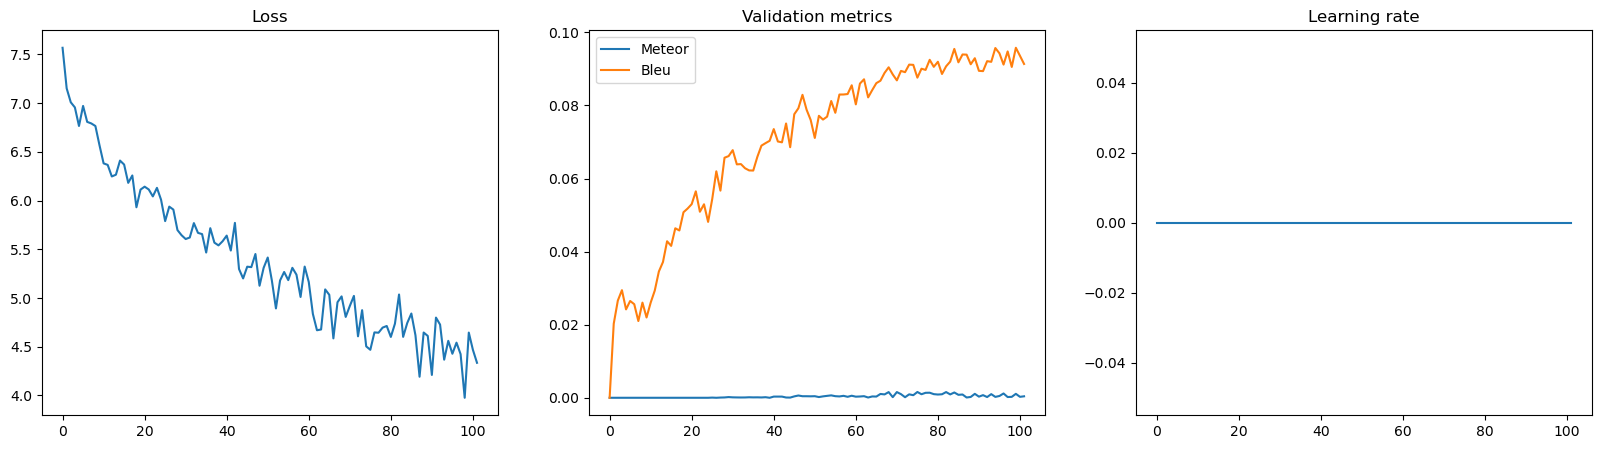

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(train_loss_list)
axs[0].set_title("Loss")
axs[1].plot(validation_meteor_list)
axs[1].plot(validation_bleu_list)
axs[1].legend(["Meteor", "Bleu"])
axs[1].set_title("Validation metrics")
axs[2].plot(train_lr_list)
axs[2].set_title("Learning rate")
plt.show()